# Time Series Anomaly Exercises

# {ಠʖಠ}

The dataset for these exercises lives in the Codeup Data Science MySQL Server. The database name is curriculum_logs.

Hint: You will need to explore the database and significantly adjust your acquisition step (yay SQL!)

### Imports

In [1]:
# imports
import numpy as np
import pandas as pd

# Visualizing
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

# Remove Limits On Viewing Dataframes
pd.set_option('display.max_columns', None)

# My Files
import env

In [75]:
# Adam's functions for detecting anomalies on a user by user basis:

def acquire_logs(user=env.user, password=env.password, host=env.host):
    '''
    This function queries the Codeup MySQL curriculum_logs database and returns a dataframe
    '''
    url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/curriculum_logs'
    query = '''
    SELECT date,
           path as endpoint,
           user_id,
           cohort_id,
           ip as source_ip
    FROM logs;
    '''
    df = pd.read_sql(query, url)
    return df

def one_user_df_prep(df, user):
    '''
    This function returns a dataframe consisting of data for only a single defined user
    '''
    df = df[df.user_id == user]
    df.date = pd.to_datetime(df.date)
    df = df.set_index(df.date)
    pages_one_user = df['endpoint'].resample('d').count()
    return pages_one_user

def compute_pct_b(pages_one_user, span, weight, user):
    '''
    This function adds the %b of a bollinger band range for the page views of a single user's log activity
    '''
    # Calculate upper and lower bollinger band
    midband = pages_one_user.ewm(span=span).mean()
    stdev = pages_one_user.ewm(span=span).std()
    ub = midband + stdev*weight
    lb = midband - stdev*weight
    
    # Add upper and lower band values to dataframe
    bb = pd.concat([ub, lb], axis=1)
    
    # Combine all data into a single dataframe
    my_df = pd.concat([pages_one_user, midband, bb], axis=1)
    my_df.columns = ['pages_one_user', 'midband', 'ub', 'lb']
    
    # Calculate percent b and relevant user id to dataframe
    my_df['pct_b'] = (my_df['pages_one_user'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])
    my_df['user_id'] = user
    return my_df

def plot_bands(my_df, user):
    '''
    This function plots the bolliger bands of the page views for a single user
    '''
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(my_df.index, my_df.pages_one_user, label='Number of Pages, User: '+str(user))
    ax.plot(my_df.index, my_df.midband, label = 'EMA/midband')
    ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
    ax.plot(my_df.index, my_df.lb, label = 'Lower Band')
    ax.legend(loc='best')
    ax.set_ylabel('Number of Pages')
    plt.show()

def find_anomalies(df, user, span, weight, plot=False):
    '''
    This function returns the records where a user's daily activity exceeded the upper limit of a bollinger band range
    '''
    
    # Reduce dataframe to represent a single user
    pages_one_user = one_user_df_prep(df, user)
    
    # Add bollinger band data to dataframe
    my_df = compute_pct_b(pages_one_user, span, weight, user)
    
    # Plot data if requested (plot=True)
    if plot:
        plot_bands(my_df, user)
    
    # Return only records that sit outside of bollinger band upper limit
    return my_df[my_df.pct_b>1]

### Acquire

In [5]:
# URL = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/curriculum_logs'
# SQL = '''
# SELECT date, time, path, user_id, cohort_id, program_id, ip,
# name, slack, start_date, end_date, created_at, updated_at
# FROM logs
# JOIN cohorts on logs.cohort_id = cohorts.id
# '''
# curr_logs = pd.read_sql(SQL, URL)
# curr_logs.head()

In [6]:
curr_logs.to_csv('curriculum_logs.csv')

In [7]:
curr_logs = pd.read_csv('curriculum_logs.csv')

In [8]:
curr_logs.head(1)

,Unnamed: 0,Unnamed: 0.1,date,time,path,user_id,cohort_id,program_id,ip,name,slack,start_date,end_date,created_at,updated_at
0,0,0,2018-01-26,09:55:03,/,1,8.0,1,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26


### Prepare

In [9]:
# concat date + time 
curr_logs['date_time']=curr_logs.date+' '+curr_logs.time

In [32]:
# change date_time to pd datetime
curr_logs.date_time = pd.to_datetime(curr_logs.date_time)

In [33]:
# change date to pd datetime
curr_logs.date = pd.to_datetime(curr_logs.date)

In [34]:
# change time to pd datetime
curr_logs.time = pd.to_datetime(curr_logs.time)

In [35]:
curr_logs.head(1)

,Unnamed: 0,Unnamed: 0.1,date,time,path,user_id,cohort_id,program_id,ip,name,slack,start_date,end_date,created_at,updated_at,date_time,staff
date_time,,,,,,,,,,,,,,,,,
2018-01-26 09:55:03,0,0,2018-01-26,2022-01-26 09:55:03,/,1,8.0,1,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,2018-01-26 09:55:03,False


In [13]:
# set index to date_time
curr_logs = curr_logs.set_index(curr_logs.date_time)

In [14]:
curr_logs.head(1)

,Unnamed: 0,Unnamed: 0.1,date,time,path,user_id,cohort_id,program_id,ip,name,slack,start_date,end_date,created_at,updated_at,date_time
date_time,,,,,,,,,,,,,,,,
2018-01-26 09:55:03,0,0,2018-01-26,09:55:03,/,1,8.0,1,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,2018-01-26 09:55:03


In [24]:
# change cohort start to datetime
curr_logs.start_date = pd.to_datetime(curr_logs.start_date)

In [27]:
# change cohort end to datetime
curr_logs.end_date = pd.to_datetime(curr_logs.end_date)

In [28]:
curr_logs.head()

,Unnamed: 0,Unnamed: 0.1,date,time,path,user_id,cohort_id,program_id,ip,name,slack,start_date,end_date,created_at,updated_at,date_time,staff
date_time,,,,,,,,,,,,,,,,,
2018-01-26 09:55:03,0,0,2018-01-26,09:55:03,/,1,8.0,1,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,2018-01-26 09:55:03,False
2018-01-26 09:56:02,1,1,2018-01-26,09:56:02,java-ii,1,8.0,1,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,2018-01-26 09:56:02,False
2018-01-26 09:56:05,2,2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,1,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,2018-01-26 09:56:05,False
2018-01-26 09:56:06,3,3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,1,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,2018-01-26 09:56:06,False
2018-01-26 09:56:24,4,4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,2,97.105.19.61,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2018-01-26 09:56:24,False


1. Label students by the program they are in.

In [21]:
curr_logs.program_id.describe()

count    847330.000000
mean          2.086004
std           0.388231
min           1.000000
25%           2.000000
50%           2.000000
75%           2.000000
max           4.000000
Name: program_id, dtype: float64

In [81]:
curr_logs.program_id.unique()

array([1, 2, 4, 3])

In [14]:
program_id = [curr_logs.program_id == 1, curr_logs.program_id == 2, curr_logs.program_id == 3, curr_logs.program_id == 4]
program = ['web_dev','web_dev','data_science','web_dev']
curr_logs['program'] = np.select(program_id, program)

In [23]:
curr_logs.head()

,Unnamed: 0,date,time,path,user_id,cohort_id,program_id,ip,name,slack,start_date,end_date,created_at,updated_at,program
0,0,2018-01-26,09:55:03,/,1,8,1,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,web_dev
1,1,2018-01-26,09:56:02,java-ii,1,8,1,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,web_dev
2,2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8,1,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,web_dev
3,3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8,1,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,web_dev
4,4,2018-01-26,09:56:24,javascript-i/conditionals,2,22,2,97.105.19.61,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,web_dev


2. Is it possible to identify the user_id of a staff member?

In [17]:
# find staff only
curr_logs.name=='Staff'

date_time
2018-01-26 09:55:03    False
2018-01-26 09:56:02    False
2018-01-26 09:56:05    False
2018-01-26 09:56:06    False
2018-01-26 09:56:24    False
                       ...  
2021-04-21 16:41:51     True
2021-04-21 16:42:02     True
2021-04-21 16:42:09     True
2021-04-21 16:44:37     True
2021-04-21 16:44:39     True
Name: name, Length: 847330, dtype: bool

In [20]:
# create column where true or false if staff
curr_logs['staff'] = curr_logs.name=='Staff'

In [30]:
curr_logs.head(1)

,Unnamed: 0,Unnamed: 0.1,date,time,path,user_id,cohort_id,program_id,ip,name,slack,start_date,end_date,created_at,updated_at,date_time,staff
date_time,,,,,,,,,,,,,,,,,
2018-01-26 09:55:03,0,0,2018-01-26,09:55:03,/,1,8.0,1,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,2018-01-26 09:55:03,False


In [ ]:
staff.user_id.unique()

In [31]:
# return the user_id where name == staff
curr_logs[["user_id"]][curr_logs["name"] == "Staff"].head()

,user_id
date_time,
2018-12-06 14:15:29,53
2018-12-06 14:25:40,314
2018-12-06 14:25:41,314
2018-12-06 15:31:29,40
2018-12-06 15:31:33,40


3. Identify students who are accessing our curriculum pages beyond the end of their time at Codeup.

In [39]:
# create column with date - end date
curr_logs['days_after_grad']=curr_logs.date-curr_logs.end_date

In [40]:
curr_logs.head(1)

,Unnamed: 0,Unnamed: 0.1,date,time,path,user_id,cohort_id,program_id,ip,name,slack,start_date,end_date,created_at,updated_at,date_time,staff,days_after_grad
date_time,,,,,,,,,,,,,,,,,,
2018-01-26 09:55:03,0,0,2018-01-26,2022-01-26 09:55:03,/,1,8.0,1,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,2018-01-26 09:55:03,False,720 days


In [48]:
curr_logs.shape

(847330, 18)

In [51]:
# return the user_id where days after grad > 0 
curr_logs[["user_id"]][curr_logs["days_after_grad"] > '0'].head()

,user_id
date_time,
2018-01-26 09:55:03,1
2018-01-26 09:56:02,1
2018-01-26 09:56:05,1
2018-01-26 09:56:06,1
2018-01-26 10:14:47,11


In [55]:
# everytime a user accesed past grad
curr_logs[["user_id"]][curr_logs["days_after_grad"] > '0'].shape

(199834, 1)

In [56]:
# number of users accessing past grad
curr_logs[curr_logs.date > curr_logs.end_date].user_id.unique().shape

(592,)

4. Identify students who present anomalous activity using the Bollinger Band method, but reduce K to 2. 

In [61]:
pages = curr_logs.path.resample('d').count()
pages.head()

date_time
2018-01-26    533
2018-01-27    230
2018-01-28    168
2018-01-29    783
2018-01-30    614
Freq: D, Name: path, dtype: int64

<AxesSubplot:xlabel='date_time'>

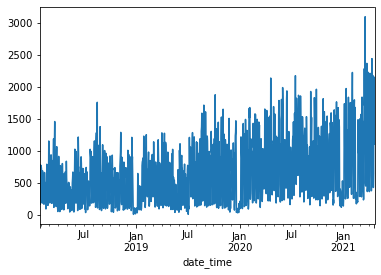

In [62]:
pages.plot()


In [65]:
# 30 days EMA (window span)
span = 30
# compute midband (The Exponential Moving Average)
midband = curr_logs.path.resample('D').count().ewm(span=span).mean()

midband.head()

date_time
2018-01-26    533.000000
2018-01-27    376.450000
2018-01-28    302.284709
2018-01-29    434.739290
2018-01-30    475.525441
Freq: D, Name: path, dtype: float64

In [66]:
# compute exponential stdev
stdev = pages.ewm(span=span).std()

stdev.head()

date_time
2018-01-26           NaN
2018-01-27    214.253355
2018-01-28    192.738756
2018-01-29    292.489456
2018-01-30    262.780177
Freq: D, Name: path, dtype: float64

In [68]:
# compute upper and lower bands
ub = midband + stdev*2
lb = midband - stdev*2
ub, lb

(date_time
 2018-01-26            NaN
 2018-01-27     804.956709
 2018-01-28     687.762221
 2018-01-29    1019.718202
 2018-01-30    1001.085795
                  ...     
 2021-04-17    2797.621100
 2021-04-18    2743.915056
 2021-04-19    2819.783757
 2021-04-20    2839.229086
 2021-04-21    2780.075594
 Freq: D, Name: path, Length: 1182, dtype: float64,
 date_time
 2018-01-26           NaN
 2018-01-27    -52.056709
 2018-01-28    -83.192803
 2018-01-29   -150.239623
 2018-01-30    -50.034912
                  ...    
 2021-04-17   -170.183548
 2021-04-18   -201.989605
 2021-04-19   -163.659948
 2021-04-20   -106.597135
 2021-04-21    -80.903769
 Freq: D, Name: path, Length: 1182, dtype: float64)

In [69]:
# concatenate ub and lb together into one df, bb
bb = pd.concat([ub, lb], axis=1)

bb.columns = ['ub', 'lb']
bb.head()

,ub,lb
date_time,,
2018-01-26,NaN,NaN
2018-01-27,804.956709,-52.056709
2018-01-28,687.762221,-83.192803
2018-01-29,1019.718202,-150.239623
2018-01-30,1001.085795,-50.034912


In [70]:
my_df = pd.concat([pages, midband, bb], axis=1)
my_df.columns = ['pages', 'midband', 'ub', 'lb']
my_df.head()

,pages,midband,ub,lb
date_time,,,,
2018-01-26,533,533.000000,NaN,NaN
2018-01-27,230,376.450000,804.956709,-52.056709
2018-01-28,168,302.284709,687.762221,-83.192803
2018-01-29,783,434.739290,1019.718202,-150.239623
2018-01-30,614,475.525441,1001.085795,-50.034912


5. Plot the access activity of these students.

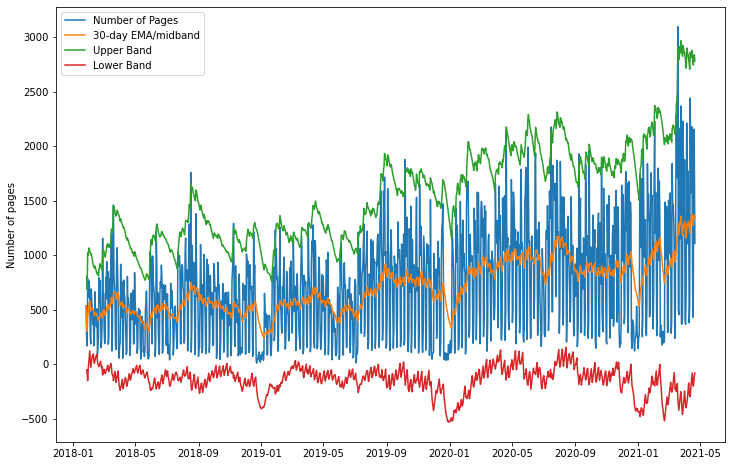

In [71]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(my_df.index, my_df.pages, label='Number of Pages')

ax.plot(my_df.index, my_df.midband, label = '30-day EMA/midband')
ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
ax.plot(my_df.index, my_df.lb, label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

In [72]:
# %b for every record in the datase (except 1st)
my_df['pct_b'] = (my_df['pages'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])

my_df.head()

,pages,midband,ub,lb,pct_b
date_time,,,,,
2018-01-26,533,533.000000,NaN,NaN,NaN
2018-01-27,230,376.450000,804.956709,-52.056709,0.329116
2018-01-28,168,302.284709,687.762221,-83.192803,0.325820
2018-01-29,783,434.739290,1019.718202,-150.239623,0.797669
2018-01-30,614,475.525441,1001.085795,-50.034912,0.631740


<AxesSubplot:xlabel='date_time'>

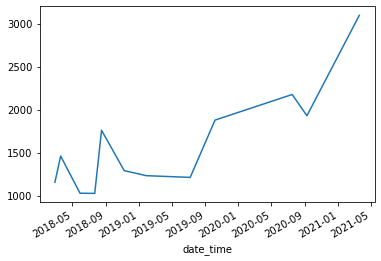

In [74]:
my_df[my_df['pct_b']>1].pages.plot()

**BONUS:** Identify users who are viewing both the web dev and data science curriculum 

In [77]:
curr_logs.head(1)

,Unnamed: 0,Unnamed: 0.1,date,time,path,user_id,cohort_id,program_id,ip,name,slack,start_date,end_date,created_at,updated_at,date_time,staff,days_after_grad
date_time,,,,,,,,,,,,,,,,,,
2018-01-26 09:55:03,0,0,2018-01-26,2022-01-26 09:55:03,/,1,8.0,1,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,2018-01-26 09:55:03,False,720 days


In [78]:
web_data = pd.DataFrame(curr_logs.groupby(by='user_id').cohort_id.nunique().sort_values(ascending=False))

In [80]:
web_data[web_data.cohort_id>=2]

,cohort_id
user_id,
64,3
88,3
1,2
148,2
312,2
308,2
268,2
257,2
248,2
